In [66]:
import torch
import torchvision
from torchvision import transforms
torch.set_printoptions(linewidth=120)

from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

import pandas as pd
import time
import json

from collections import OrderedDict
from collections import namedtuple
from itertools import product

from IPython.display import display, clear_output


### **Train set**

In [2]:
train_set = torchvision.datasets.FashionMNIST(
    root='./data/FashionMNIST',train=True,download=False,
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
)

In [3]:
print('train size', len(train_set))
print('train target',train_set.targets)

print('train set bin count', train_set.targets.bincount())

sample = next(iter(train_set))
image, label = sample

print('image shape', image.shape)

train size 60000
train target tensor([9, 0, 0,  ..., 3, 0, 5])
train set bin count tensor([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])
image shape torch.Size([1, 28, 28])


##### **Display image**

label: 9


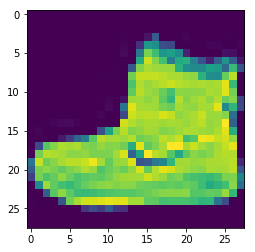

In [4]:
plt.imshow(image.squeeze())
print('label:', label)

#### **Batch data**

In [5]:
train_loader = DataLoader(train_set,batch_size=64)
batch = next(iter(train_loader))
images,labels = batch
print(labels.shape)
print(images.shape)

torch.Size([64])
torch.Size([64, 1, 28, 28])


grid shape torch.Size([3, 122, 482])
grid transpose shape torch.Size([122, 482, 3])
labels: tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3, 6, 6, 0, 8, 5,
        2, 1, 6, 6, 7, 9, 5, 9, 2, 7, 3, 0, 3, 3, 3, 7, 2, 2, 6, 6, 8, 3, 3, 5, 0, 5, 5])


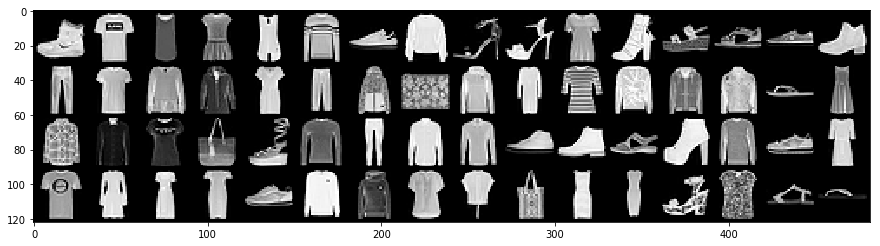

In [6]:
grid = torchvision.utils.make_grid(images,nrow=16)
print('grid shape',grid.shape)
plt.figure(figsize=(15,15)) #15X15
grid_t = np.transpose(grid,(1,2,0))
print('grid transpose shape',grid_t.shape)
plt.imshow(grid_t)
print('labels:',labels)

### **NETWORK DEFINITION**

In [7]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=12,kernel_size=5)
        self.fc1 = nn.Linear(in_features=12*4*4,out_features=120)
        self.fc2 = nn.Linear(in_features=120,out_features=60)
        self.out = nn.Linear(in_features=60,out_features=10)
        
    def forward(self,t):
        #forward
        # 1st hidden conv
        t = self.conv1(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        # 2nd hidden conv
        t= self.conv2(t)
        t = F.relu(t)
        t = F.max_pool2d(t,kernel_size=2,stride=2)
        
        #1st linear Dense layer
        t = t.reshape(-1,12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        
        #2nd linear Dense Layer
        t = self.fc2(t)
        t = F.relu(t)
        
        #prediction layer
        t= self.out(t)
        
        #we will use xentropy loss function which implicitely compute softmax
        #t = F.softmax(t,dim=1)
        
        return t
        

In [8]:
network = Network()
print(network)
for name , param in network.named_parameters():
    print(f"{name} ->  {param.shape}")

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)
conv1.weight ->  torch.Size([6, 1, 5, 5])
conv1.bias ->  torch.Size([6])
conv2.weight ->  torch.Size([12, 6, 5, 5])
conv2.bias ->  torch.Size([12])
fc1.weight ->  torch.Size([120, 192])
fc1.bias ->  torch.Size([120])
fc2.weight ->  torch.Size([60, 120])
fc2.bias ->  torch.Size([60])
out.weight ->  torch.Size([10, 60])
out.bias ->  torch.Size([10])



***

### Understanding Layer size for CNN

#### CNN Ouput ($O_h$) size formula

* Suppose we have a **NxN** input size
* Suppose we have a __FXF__
* Suppose we have a padding of **P** and a stride of __S__

<div style='font-size:24px;font-weight:600'>
$O_h=\frac{N_h - F_h + 2P}{S} + 1$
</div>


***



In [9]:
# torch.set_grad_enabled(False)
torch.set_grad_enabled(True) # default is true

### **Prediction**

In [10]:
def get_correct_preds_number(preds,labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

preds = network(images)
print('show one prediction',preds[0])
print('preds argmax',preds.argmax(dim=1))
# print('preds all batch data',preds.data)
print('correct preds number', get_correct_preds_number(preds,labels))

show one prediction tensor([-0.0902, -0.0621,  0.0253, -0.1153,  0.0364,  0.0396,  0.0610, -0.0413, -0.1018,  0.0138],
       grad_fn=<SelectBackward>)
preds argmax tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6])
correct preds number 7


#### **Training for multiple epoches + Tensorboard**

In [11]:
network = Network()
train_loader_ = DataLoader(train_set,batch_size=16,shuffle=True)
optimizer = optim.Adam(network.parameters(),lr=0.001)

images, labels = next(iter(train_loader_))
grid = torchvision.utils.make_grid(images)

# tb = SummaryWriter()
# tb.add_image('images', grid)
# tb.add_graph(network, images)


for epoch in range(10):
    final_loss = 0
    total_correct = 0
    for batch_ in train_loader_:
        images_,labels_ = batch_
        preds_  =  network(images_)
        loss = F.cross_entropy(preds_,labels_)
        optimizer.zero_grad()
        loss.backward() #calculate gradients
        optimizer.step() #update the weights by taking on step
        final_loss += loss.item()
        total_correct += get_correct_preds_number(preds_,labels_)
#     tb.add_scalar('Loss', final_loss, epoch)
#     tb.add_scalar('Number Correct', total_correct,epoch)
#     tb.add_scalar('Accuracy', total_correct/len(train_set),epoch)
    
#     tb.add_histogram('conv1.bias',network.conv1.bias,epoch)
#     tb.add_histogram('conv1.weight',network.conv1.weight,epoch)
#     tb.add_histogram('conv1.weight.grad',network.conv1.weight.grad,epoch)
    
    print("Epoch: ",epoch,"Total correct:", total_correct, "Final Loss",final_loss)
    print('Accuracy', total_correct/len(train_set))
    
# tb.close()

Epoch:  0 Total correct: 46772 Final Loss 2201.4938634112477
Accuracy 0.7795333333333333
Epoch:  1 Total correct: 51512 Final Loss 1443.7507678419352
Accuracy 0.8585333333333334
Epoch:  2 Total correct: 52599 Final Loss 1249.6915264576674
Accuracy 0.87665
Epoch:  3 Total correct: 53216 Final Loss 1144.1145441904664
Accuracy 0.8869333333333334
Epoch:  4 Total correct: 53551 Final Loss 1070.641535192728
Accuracy 0.8925166666666666
Epoch:  5 Total correct: 54015 Final Loss 1002.4746004752815
Accuracy 0.90025
Epoch:  6 Total correct: 54329 Final Loss 956.7673613168299
Accuracy 0.9054833333333333
Epoch:  7 Total correct: 54482 Final Loss 917.2040614783764
Accuracy 0.9080333333333334
Epoch:  8 Total correct: 54742 Final Loss 878.7498175986111
Accuracy 0.9123666666666667
Epoch:  9 Total correct: 54894 Final Loss 847.8560223747045
Accuracy 0.9149


#### **ALL PREDICTIONS**

In [12]:
@torch.no_grad() #disable grad calculation overhead
def get_all_preds(model,loader):
    all_preds = torch.tensor([])
    for batches in loader:
        imgs,lbls = batches
        preds = model(imgs)
        all_preds = torch.cat((all_preds,preds),dim=0)
    return all_preds

In [13]:
pred_loader = DataLoader(train_set, batch_size=10000)
all_preds = get_all_preds(network,pred_loader)

In [14]:
print('all_preds shape',all_preds.shape)
print('all_preds require grad', all_preds.requires_grad)

all_preds shape torch.Size([60000, 10])
all_preds require grad False


In [15]:
all_correct_preds = get_correct_preds_number(all_preds,train_set.targets)
print('all correct preds:', all_correct_preds)
print('accuracy for all:', all_correct_preds/len(train_set.targets))

all correct preds: 55592
accuracy for all: 0.9265333333333333


#### **Build Confusion Matrix**

In [16]:
stacked = torch.stack((train_set.targets, all_preds.argmax(dim=1)),dim=1)
print('stacked shape',stacked.shape)
print('stacked', stacked)

cfm = torch.zeros([10,10],dtype=torch.int32)
for row in stacked:
    [tl,pl] = row.tolist()
    cfm[tl,pl] = cfm[tl,pl]+1
    
cfm

stacked shape torch.Size([60000, 2])
stacked tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])


tensor([[5313,    2,   86,   88,   14,    0,  475,    0,   22,    0],
        [   1, 5901,    4,   78,    7,    0,    8,    0,    1,    0],
        [  58,    1, 5158,   32,  537,    0,  209,    0,    5,    0],
        [  71,    8,   26, 5617,  209,    0,   61,    0,    8,    0],
        [   5,    0,  141,   81, 5591,    0,  178,    0,    4,    0],
        [   0,    0,    0,    0,    0, 5895,    1,   40,    3,   61],
        [ 557,    5,  341,  110,  430,    0, 4530,    0,   27,    0],
        [   0,    0,    0,    0,    0,   79,    0, 5824,   11,   86],
        [   5,    1,    4,   12,   13,    1,   11,    0, 5953,    0],
        [   0,    0,    0,    0,    0,    9,    0,  177,    4, 5810]], dtype=torch.int32)

In [17]:
import seaborn as sn
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.style.use('seaborn')

In [18]:
from plotcm import prettyplot_confusion_matrix, plot_confusion_matrix

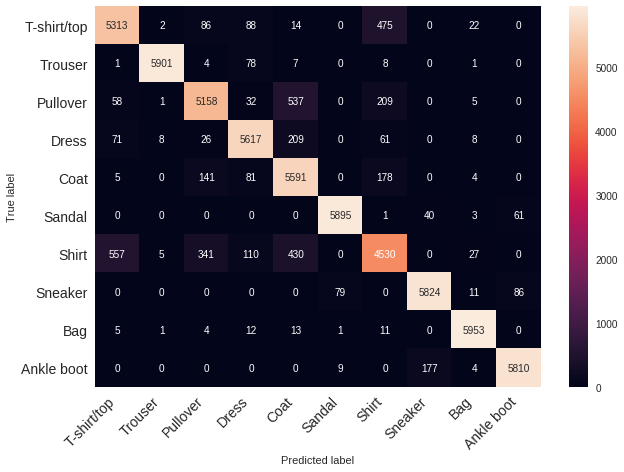

In [19]:
prettyplot_confusion_matrix(cfm.numpy(),train_set.classes);

Confusion matrix, without normalization


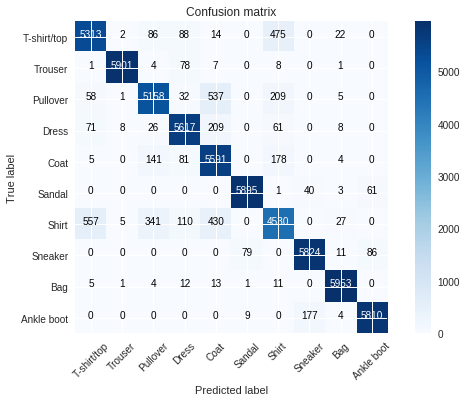

In [20]:
plot_confusion_matrix(cfm.numpy(),train_set.classes);

In [21]:
# def run_train(lr,batch_size,shuffle):
#     network = Network()
#     train_loader_ = DataLoader(train_set,batch_size=batch_size,shuffle=shuffle)
#     optimizer = optim.Adam(network.parameters(),lr=lr)

#     images, labels = next(iter(train_loader_))
#     grid = torchvision.utils.make_grid(images)
    
#     comment = f"-lr={lr} - batch_size={batch_size} - shuffle={shuffle}"
#     print(comment)
#     tb = SummaryWriter(comment=comment)
#     tb.add_image('images', grid)
#     tb.add_graph(network, images)

#     for epoch in range(10):
#         final_loss = 0
#         total_correct = 0
#         for batch_ in train_loader_:
#             images_,labels_ = batch_
#             preds_  =  network(images_)
#             loss = F.cross_entropy(preds_,labels_)
#             optimizer.zero_grad()
#             loss.backward() #calculate gradients
#             optimizer.step() #update the weights by taking on step
#             final_loss += loss.item()
#             total_correct += get_correct_preds_number(preds_,labels_)
#         tb.add_scalar('Loss', final_loss, epoch)
#         tb.add_scalar('Number Correct', total_correct,epoch)
#         tb.add_scalar('Accuracy', total_correct/len(train_set),epoch)

#         tb.add_histogram('conv1.bias',network.conv1.bias,epoch)
#         tb.add_histogram('conv1.weight',network.conv1.weight,epoch)
#         tb.add_histogram('conv1.weight.grad',network.conv1.weight.grad,epoch)

#         print("Epoch: ",epoch,"Total correct:", total_correct, "Final Loss",final_loss)
#         print('Accuracy', total_correct/len(train_set))

#     tb.close()